# Examining Cloud Information in the RRFS Ensemble

shawn.s.murdzek@noaa.gov

Machine: Jet  
Environment: adb_graphics

### General Notes:
- I recommend omitting postage stamp plots for large domains, as these plots take considerable time and memory to generate

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import yaml
import metpy.calc as mc
from metpy.units import units
import metpy.constants as const

import pyDA_utils.plot_model_data as pmd
import pyDA_utils.bufr as bufr
import pyDA_utils.ensemble_utils as eu

In [16]:
from importlib import reload
eu = reload(eu)

# Input Parameters

In [2]:
"""
Read Input Parameters
"""

case = 'CONUS_2022020113'
yml_fname = '/lfs4/BMC/wrfruc/murdzek/src/py_scripts/cloud_da/cases/{c}/{c}_input.yml'.format(c=case)
with open(yml_fname, 'r') as fptr:
    param = yaml.safe_load(fptr)

# UPP output for each ensemble member
str_format = param['str_format']
prslev_fnames = {}
natlev_fnames = {}
for i in range(1, param['nmem']+1):
    prslev_fnames['mem{num:04d}'.format(num=i)] = str_format.format(num=i, lev='prslev')
    natlev_fnames['mem{num:04d}'.format(num=i)] = str_format.format(num=i, lev='natlev')
prslev_vars = param['prslev_vars']

# BUFR file name
bufr_fname = param['bufr_fname']

# Subset domain
min_lon = param['min_lon']
max_lon = param['max_lon']
min_lat = param['min_lat']
max_lat = param['max_lat']
z_ind = param['z_ind']

# Variables to include in state matrix (assumed to be 3D)
state_vars = param['state_vars']

# Tag for output files
save_tag = param['save_tag']
out_dir = param['out_dir']

# "Target" (lat, lon) coordinate for BEC spatial plots
do_bec = param['do_bec']
bec_lat = param['bec_lat']
bec_lon = param['bec_lon']
bec_klvl = param['bec_klvl']

# Read in Ensemble and BUFR Output

In [3]:
"""
Read in ensemble output and BUFR obs
"""

start = dt.datetime.now()
ens_obj = eu.ensemble(natlev_fnames, extra_fnames=prslev_fnames, extra_fields=prslev_vars, 
                      bufr_csv_fname=bufr_fname, lat_limits=[min_lat, max_lat], lon_limits=[min_lon, max_lon],
                      zind=z_ind, state_fields=state_vars, bec=do_bec)
print('elapsed time = {t:.2f} s'.format(t=(dt.datetime.now() - start).total_seconds()))
print('Shape of subset =', ens_obj.subset_ds['mem0001']['TMP_P0_L105_GLC0'].shape)

reading member mem0001
reading member mem0002
reading member mem0003
reading member mem0004
reading member mem0005
reading member mem0006
reading member mem0007
reading member mem0008
reading member mem0009
reading member mem0010
reading member mem0011
reading member mem0012
reading member mem0013
reading member mem0014
reading member mem0015
reading member mem0016
reading member mem0017
reading member mem0018
reading member mem0019
reading member mem0020
reading member mem0021
reading member mem0022
reading member mem0023
reading member mem0024
reading member mem0025
reading member mem0026
reading member mem0027
reading member mem0028
reading member mem0029
reading member mem0030


/contrib/miniconda3/4.5.12/envs/adb_graphics/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


elapsed time = 594.53 s
Shape of subset = (1, 930, 1798)


In [4]:
"""
Test Observation Subsetting
"""

bufr_field = 'CEILING'
bufr_subset = ['ADPSFC']
bufr_nonan = 'TOB'     # Only use a row if this ob is not NaN

###

start = dt.datetime.now()
subset_obs = ens_obj._subset_bufr(bufr_subset, bufr_nonan)
print('elapsed time = {t:.2f} s'.format(t=(dt.datetime.now() - start).total_seconds()))

elapsed time = 2.95 s


In [8]:
"""
Testing Interpolation to Ob Locations (for a SINGLE ensemble member): Generating Interpolation Fct
"""

import scipy.interpolate as si

model_field = 'TMP_P0_L105_GLC0'
klvl = 10
mem = ens_obj.mem_names[0]

###

# Obtain input arrays
print('getting 1D input arrays')
start = dt.datetime.now()
mlat1d = np.ravel(ens_obj.subset_ds[ens_obj.mem_names[0]]['gridlat_0'])
mlon1d = np.ravel(ens_obj.subset_ds[ens_obj.mem_names[0]]['gridlon_0'])
z = np.ravel(ens_obj.subset_ds[mem][model_field].values)
print('elapsed time = {t:.2f} s'.format(t=(dt.datetime.now() - start).total_seconds()))
print('size of 1D arrays =', np.shape(mlat1d))
print()

# Generating interpolation function
print('generating interpolation fct')
start = dt.datetime.now()
interp_fct = si.NearestNDInterpolator(list(zip(mlon1d, mlat1d)), z)
print('elapsed time = {t:.2f} s'.format(t=(dt.datetime.now() - start).total_seconds()))
print()

# Interpolating to ob locations
lat = subset_obs['YOB'].values
lon = subset_obs['XOB'].values-360.
print('interpolating to ob locations (n = {n})'.format(n=len(lat)))
start = dt.datetime.now()
out = interp_fct(lon, lat)
print('elapsed time = {t:.2f} s'.format(t=(dt.datetime.now() - start).total_seconds()))
print('fraction of interp values that are NaN = {f:.2f}'.format(f=np.sum(np.isnan(out))/len(out)))
print()

getting 1D input arrays
elapsed time = 0.07 s
size of 1D arrays = (1672140,)

generating interpolation fct
elapsed time = 38.94 s

interpolating to ob locations (n = 2514)
elapsed time = 0.01 s
fraction of interp values that are NaN = 0.00



In [10]:
lat = subset_obs['YOB'].values + 30
lon = subset_obs['XOB'].values
print('interpolating to ob locations (n = {n})'.format(n=len(lat)))
start = dt.datetime.now()
out = interp_fct(lon, lat)
print('elapsed time = {t:.2f} s'.format(t=(dt.datetime.now() - start).total_seconds()))
print('fraction of interp values that are NaN = {f:.2f}'.format(f=np.sum(np.isnan(out))/len(out)))
print()

interpolating to ob locations (n = 2514)
elapsed time = 0.00 s
fraction of interp values that are NaN = 0.00



In [17]:
import matplotlib.path as mplPath

lon2d = ens_obj.subset_ds[ens_obj.mem_names[0]]['gridlon_0'].values
lat2d = ens_obj.subset_ds[ens_obj.mem_names[0]]['gridlat_0'].values
idim, jdim = lon2d.shape

edge_pts = [[lon2d[i, j], lat2d[i, j]] 
            for i, j in zip(list(range(idim)) + [idim-1]*jdim + list(range(idim-1, -1, -1)) + [0]*jdim,
                            [0]*idim + list(range(jdim)) + [jdim-1]*idim + list(range(jdim-1, -1, -1)))]

path = mplPath.Path(edge_pts)

test_pts = [[-95.67, 39.05],
            [-105.27, 40.02],
            [11.58, 48.14],
            [-72.67, 41.77],
            [-122.33, 47.61],
            [-157.86, 21.31],
            [-81.78, 24.56],
            [-80.48, 25.47]]

out = path.contains_points(test_pts)
print(out)

[ True  True False  True  True False False False]


In [57]:
lat2d_original = ens_obj.ds['mem0001']['gridlat_0'].values
lon2d_original = ens_obj.ds['mem0001']['gridlon_0'].values

print(min_lat)
print(np.amin(np.array(edge_pts)[:, 1]))
print(np.amin(lat2d))
print(lat2d_original.shape)
print(lon2d_original.shape)
print(ens_obj.lat_limits)
print(ens_obj.lon_limits)
print(ens_obj._get_corner_ind(ens_obj.lon_limits[0], ens_obj.lon_limits[1], 21, ens_obj.lat_limits[1], debug=True))
print(lat2d_original[0, 0], lon2d_original[0, 0])
print(lat2d_original[128, 0], lon2d_original[128, 0])
print(np.unravel_index(np.argmin((lat2d_original - 21)**2 + 
                           (lon2d_original - (-134.1))**2), lon2d_original.shape))
print(np.argmin((lat2d_original - 10)**2 + 
                           (lon2d_original - (-134.1))**2))
print(lat2d_original[0, 0])
print(lon2d_original[0, 0])

21.0
24.3402
24.3402
(1059, 1799)
(1059, 1799)
[21.0, 53.0]
[-134.1, -60.9]
iind = [ 128 1058  128 1058]
jind = [   0   35 1798 1763]
(128, 1058, 0, 1798)
21.138115 -122.71953
24.3402 -123.71577
(128, 0)
0
21.138115
-122.71953


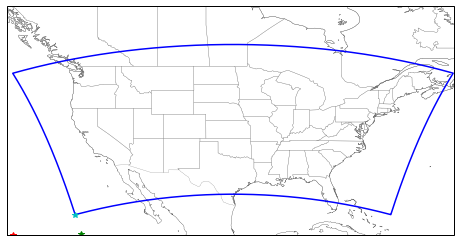

In [60]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.plot(np.array(edge_pts)[:, 0], np.array(edge_pts)[:, 1], 'b-', transform=ccrs.PlateCarree())
ax.plot([-134.1], [21], 'r*')
ax.plot([-123.71], [24.34], 'c*')
ax.plot([-122.719], [21.138], 'g*')
ax.set_extent([-135, max_lon, min_lat, max_lat])
ax.coastlines('50m', edgecolor='gray', linewidth=0.25)
borders = cfeature.NaturalEarthFeature(category='cultural',
                                        scale='50m',
                                       facecolor='none',
                                       name='admin_1_states_provinces')
ax.add_feature(borders, linewidth=0.25, edgecolor='gray')
#lakes = cfeature.NaturalEarthFeature(category='physical',
#                                     scale='50m',
#                                     facecolor='none',
#                                     name='lakes')
#ax.add_feature(lakes, linewidth=0.25, edgecolor='gray')


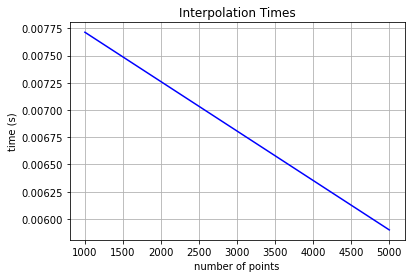

fraction of interp values that are NaN = 0.65


In [34]:
lat = subset_obs['YOB'].values
lon = subset_obs['XOB'].values-360.

npts = np.array([1e3, 5e3], dtype=int)
times = np.zeros(npts.shape)
for i, n in enumerate(npts):
    start = dt.datetime.now()
    out = interp_fct(lon[:n], lat[:n])
    times[i] = (dt.datetime.now() - start).total_seconds()

plt.figure()
plt.plot(npts, times, 'b-')
plt.grid()
plt.xlabel('number of points')
plt.ylabel('time (s)')
plt.title('Interpolation Times')
plt.show()

print('fraction of interp values that are NaN = {f:.2f}'.format(f=np.sum(np.isnan(out))/len(out)))

In [4]:
"""
Plot Rank For Each Ceiling Ob
"""

model_field = 'HGT_P0_L215_GLC0'
klvl = np.nan
save_fname_spatial = '{d}/ceiling_ranks_{tag}.png'.format(d=out_dir, tag=save_tag)
save_fname_hist = '{d}/ceiling_ranks_hist_{tag}.png'.format(d=out_dir, tag=save_tag)

bufr_field = 'CEILING'
bufr_subset = ['ADPSFC']
bufr_nonan = 'TOB'     # Only use a row if this ob is not NaN

###

# Interpolate ensemble members to ob locations
start = dt.datetime.now()
subset_obs = ens_obj._subset_bufr(bufr_subset, bufr_nonan)
ens_interp = ens_obj.interp_model_2d(model_field, subset_obs['YOB'].values, subset_obs['XOB'].values-360., 
                                     zind=klvl, method='nearest', verbose=True)
print('finished with interpolation')
print('elapsed time = {t:.2f} s'.format(t=(dt.datetime.now() - start).total_seconds()))

Performing interpolation for mem0001
Performing interpolation for mem0002
Performing interpolation for mem0003
Performing interpolation for mem0004
Performing interpolation for mem0005
Performing interpolation for mem0006
Performing interpolation for mem0007
Performing interpolation for mem0008
Performing interpolation for mem0009
Performing interpolation for mem0010
Performing interpolation for mem0011
Performing interpolation for mem0012
Performing interpolation for mem0013
Performing interpolation for mem0014
Performing interpolation for mem0015
Performing interpolation for mem0016
Performing interpolation for mem0017
Performing interpolation for mem0018
Performing interpolation for mem0019
Performing interpolation for mem0020
Performing interpolation for mem0021
Performing interpolation for mem0022
Performing interpolation for mem0023
Performing interpolation for mem0024
Performing interpolation for mem0025
Performing interpolation for mem0026
Performing interpolation for mem0027
P

In [5]:
# Determine ranks
start = dt.datetime.now()
ranks = np.zeros(len(subset_obs))
ob_vals = subset_obs[bufr_field].values
ens_vals = mc.geopotential_to_height(ens_interp.loc[:, ens_obj.mem_names].values * units.m * const.g).to('m').magnitude
for i in range(len(ranks)):
    ranks[i] = np.sum(ob_vals[i] > ens_vals[i, :])

# Change NaNs to be an arbitrarily large number
ob_vals[np.isnan(ob_vals)] = 1e8
ens_vals[np.isnan(ens_vals)] = 1e9

print('finished with pre-processing')
print('elapsed time = {t:.2f} s'.format(t=(dt.datetime.now() - start).total_seconds()))

finished with pre-processing
elapsed time = 0.06 s


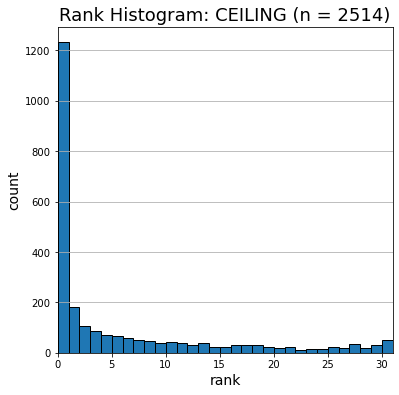

In [6]:
# Plot ranks: Histogram
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
ax.hist(ranks, bins=np.arange(0, param['nmem']+2), edgecolor='k', linewidth=1)
ax.set_title('Rank Histogram: {v} (n = {n})'.format(v=bufr_field, n=len(ranks)), size=18)
ax.set_xlabel('rank', size=14)
ax.set_ylabel('count', size=14)
ax.grid(axis='y')
ax.set_xlim([0, param['nmem']+1])
plt.savefig(save_fname_hist)

making plot


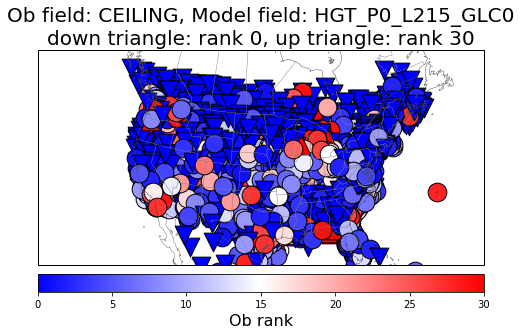

In [7]:
# Plot ranks: Spatial plot
print('making plot')
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertConformal())
for i in range(len(ranks)):
    if ranks[i] == 0:
        m = 'v'
    elif ranks[i] == param['nmem']:
        m = '^'
    else:
        m = 'o'
    cax = ax.scatter(subset_obs.loc[i, 'XOB'], subset_obs.loc[i, 'YOB'], c=ranks[i], 
                     s=350, cmap='bwr', vmin=0, vmax=param['nmem'], marker=m, linewidths=1, edgecolors='k',
                     transform=ccrs.PlateCarree(), alpha=1)
    
ax.set_title('Ob field: {ob_f}, Model field: {m_f}\n'.format(ob_f=bufr_field, m_f=model_field) +
             'down triangle: rank 0, up triangle: rank {rmax}'.format(rmax=param['nmem']), size=20)
ax.set_extent([min_lon, max_lon, min_lat, max_lat])
ax.coastlines('50m', edgecolor='gray', linewidth=0.25)
borders = cfeature.NaturalEarthFeature(category='cultural',
                                        scale='50m',
                                       facecolor='none',
                                       name='admin_1_states_provinces')
ax.add_feature(borders, linewidth=0.25, edgecolor='gray')
#lakes = cfeature.NaturalEarthFeature(category='physical',
#                                     scale='50m',
#                                     facecolor='none',
#                                     name='lakes')
#ax.add_feature(lakes, linewidth=0.25, edgecolor='gray')

cbar = plt.colorbar(cax, ax=ax, orientation='horizontal', pad=0.02, aspect=25)
cbar.set_label('Ob rank', size=16)
plt.savefig(save_fname_spatial)

In [ ]:
"""
Plot Rank For Each Ceiling Ob
"""

model_field = 'HGT_P0_L215_GLC0'
klvl = np.nan
save_fname_spatial = '{d}/ceiling_ranks_{tag}.png'.format(d=out_dir, tag=save_tag)
save_fname_hist = '{d}/ceiling_ranks_hist_{tag}.png'.format(d=out_dir, tag=save_tag)

bufr_field = 'CEILING'
bufr_subset = ['ADPSFC']
bufr_nonan = 'TOB'     # Only use a row if this ob is not NaN

###

# Interpolate ensemble members to ob locations
start = dt.datetime.now()
subset_obs = ens_obj._subset_bufr(bufr_subset, bufr_nonan)
ens_interp = ens_obj.interp_model_2d(model_field, subset_obs['YOB'].values, subset_obs['XOB'].values-360., 
                                     zind=klvl, method='nearest')
print('finished with interpolation')
print('elapsed time = {t:.2f} s'.format(t=(dt.datetime.now() - start).total_seconds()))

# Determine ranks
start = dt.datetime.now()
ranks = np.zeros(len(subset_obs))
ob_vals = subset_obs[bufr_field].values
ens_vals = mc.geopotential_to_height(ens_interp.loc[:, ens_obj.mem_names].values * units.m * const.g).to('m').magnitude
for i in range(len(ranks)):
    ranks[i] = np.sum(ob_vals[i] > ens_vals[i, :])

# Change NaNs to be an arbitrarily large number
ob_vals[np.isnan(ob_vals)] = 1e8
ens_vals[np.isnan(ens_vals)] = 1e9

print('finished with pre-processing')
print('elapsed time = {t:.2f} s'.format(t=(dt.datetime.now() - start).total_seconds()))

# Plot ranks: Spatial plot
print('making plot')
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertConformal())
for i in range(len(ranks)):
    if ranks[i] == 0:
        m = 'v'
    elif ranks[i] == param['nmem']:
        m = '^'
    else:
        m = 'o'
    cax = ax.scatter(subset_obs.loc[i, 'XOB'], subset_obs.loc[i, 'YOB'], c=ranks[i], 
                     s=350, cmap='bwr', vmin=0, vmax=param['nmem'], marker=m, linewidths=1, edgecolors='k',
                     transform=ccrs.PlateCarree(), alpha=1)
    
ax.set_title('Ob field: {ob_f}, Model field: {m_f}\n'.format(ob_f=bufr_field, m_f=model_field) +
             'down triangle: rank 0, up triangle: rank {rmax}'.format(rmax=param['nmem']), size=20)
ax.set_extent([min_lon, max_lon, min_lat, max_lat])
ax.coastlines('50m', edgecolor='gray', linewidth=0.25)
borders = cfeature.NaturalEarthFeature(category='cultural',
                                        scale='50m',
                                       facecolor='none',
                                       name='admin_1_states_provinces')
ax.add_feature(borders, linewidth=0.25, edgecolor='gray')
#lakes = cfeature.NaturalEarthFeature(category='physical',
#                                     scale='50m',
#                                     facecolor='none',
#                                     name='lakes')
#ax.add_feature(lakes, linewidth=0.25, edgecolor='gray')

cbar = plt.colorbar(cax, ax=ax, orientation='horizontal', pad=0.02, aspect=25)
cbar.set_label('Ob rank', size=16)
plt.savefig(save_fname_spatial)

# Plot ranks: Histogram
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
ax.hist(ranks, bins=np.arange(0, param['nmem']+2), edgecolor='k', linewidth=1)
ax.set_title('Rank Histogram: {v} (n = {n})'.format(v=bufr_field, n=len(ranks)), size=18)
ax.set_xlabel('rank', size=14)
ax.set_ylabel('count', size=14)
ax.grid(axis='y')
ax.set_xlim([0, param['nmem']+1])
plt.savefig(save_fname_hist)

print('elapsed time = {t:.2f} s'.format(t=(dt.datetime.now() - start).total_seconds()))

making plot


In [10]:
np.mean(ens_obj.ds['mem0001']['HGT_P0_L105_GLC0'][17, :, :] - ens_obj.ds['mem0001']['HGT_P0_L1_GLC0'])

<xarray.DataArray ()>
array(971.7851, dtype=float32)
Coordinates:
    lv_HYBL2  float32 18.0